# casual registeredを別々にデータで学習 by グリッドサーチ


In [1]:
import numpy as np
import pandas as pd

In [2]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
#ls

In [4]:
#cd ./drive/MyDrive/

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [35]:
test_df = pd.read_csv("./input/test.csv")
train_df = pd.read_csv("./input/train.csv")

In [7]:
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [8]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [9]:
test_df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [10]:
#データタイム型を年、月、週、時間に分割する
train_df['datetime_original'] = pd.to_datetime(train_df['datetime'])

train_df['year']=pd.DatetimeIndex(train_df['datetime_original']).year
train_df['month']=pd.DatetimeIndex(train_df['datetime_original']).month
train_df['weekday']=pd.DatetimeIndex(train_df['datetime_original']).weekday
train_df['hour']=pd.DatetimeIndex(train_df['datetime_original']).hour

In [11]:
#変換できているか確認
train_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,datetime_original,year,month,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,1,5,0


In [36]:
#データタイム型を年、月、週、時間に分割する
test_df['datetime_original'] = pd.to_datetime(test_df['datetime'])

test_df['year']=pd.DatetimeIndex(test_df['datetime_original']).year
test_df['month']=pd.DatetimeIndex(test_df['datetime_original']).month
test_df['weekday']=pd.DatetimeIndex(test_df['datetime_original']).weekday
test_df['hour']=pd.DatetimeIndex(test_df['datetime_original']).hour

In [37]:
test_df.head(1)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime_original,year,month,weekday,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011-01-20,2011,1,3,0


In [14]:
#sklearnとxgboostをインポート
import xgboost as xgb
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [15]:
#学習データの整形
df_y = train_df['casual']
df_X = train_df.drop(['datetime','casual','registered','count','datetime_original'],axis=1)

In [16]:
df_y = df_y.astype(int)
df_X = df_X.astype(int)

In [17]:
df_y.head(3)

0    3
1    8
2    5
Name: casual, dtype: int32

In [18]:
df_X.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,weekday,hour
0,1,0,0,1,9,14,81,0,2011,1,5,0
1,1,0,0,1,9,13,80,0,2011,1,5,1
2,1,0,0,1,9,13,80,0,2011,1,5,2


In [19]:
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True)

In [20]:
"""
#xgboostようにデータを整形
X_train = xgb.DMatrix(X_train)
X_test = xgb.DMatrix(X_test)
y_train = xgb.DMatrix(y_train)
y_test = xgb.DMatrix(y_test)
"""

'\n#xgboostようにデータを整形\nX_train = xgb.DMatrix(X_train)\nX_test = xgb.DMatrix(X_test)\ny_train = xgb.DMatrix(y_train)\ny_test = xgb.DMatrix(y_test)\n'

In [21]:
#グリッドサーチによるパラメータチューニング
from sklearn.model_selection import GridSearchCV

In [22]:
%%time
#合計45万通りの組み合せすべて検証は多すぎる
cv_params ={'max_depth':[10,11,12],
            'min_child_weight':[3,4,5],
            'gamma':[0.4,0.5,0.6],
            'subsample':[0.7,0.8,0.9],
            'colsample_bytree':[ 0.9,1.0,1.1],
            'reg_alpha':[100, 150,200],
            'n_estimators':[1000],
            'reg_lambda':[0.1,1,10],
            'learning_rate':[0.1]
            }

model = xgb.XGBRegressor(silent=False,n_jobs=-1)
model_grid = GridSearchCV(model, cv_params, cv=5, n_jobs=-1)
model_grid.fit(X_train,
                y_train,
                early_stopping_rounds=50,
                eval_set=[(X_test, y_test)],
                eval_metric='rmsle',
                verbose=0)
print('optimal_parameters\n', model_grid.best_params_)

[20:38:35] WARNING: ..\src\learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


optimal_parameters
 {'colsample_bytree': 1.0, 'gamma': 0.5, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 5, 'n_estimators': 1000, 'reg_alpha': 100, 'reg_lambda': 0.1, 'subsample': 0.8}
Wall time: 54min 3s


In [23]:
#パラメータが最適化されたモデルを作成
opt_model = model_grid.best_estimator_
#予測
y_pred_train = opt_model.predict(X_train)
y_pred_test = opt_model.predict(X_test)

In [24]:
y_pred_train = y_pred_train.astype(int)
y_pred_train[y_pred_train<0] = 0
y_pred_test = y_pred_test.astype(int)
y_pred_test[y_pred_test<0] = 0

In [25]:
# 学習モデルの評価（RMSEを計算）
from sklearn.metrics import mean_squared_log_error
print('RMSE(train data):',round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print('RMSLE(train data):',round(np.sqrt(mean_squared_log_error(y_train, y_pred_train)),3))
print('RMSE(test data):',round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print('RMSLE(test data):',round(np.sqrt(mean_squared_log_error(y_test, y_pred_test)),3))

RMSE(train data): 6.81
RMSLE(train data): 0.386
RMSE(test data): 12.895
RMSLE(test data): 0.481


In [26]:
visu_df = pd.DataFrame([y_pred_train,y_train], index = ['y_pred','y'])
visu_df = visu_df.T
visu_df

,y_pred,y
0,29,26
1,13,7
2,208,208
3,50,56
4,106,89
...,...,...
8703,21,18
8704,140,127
8705,15,12
8706,39,53


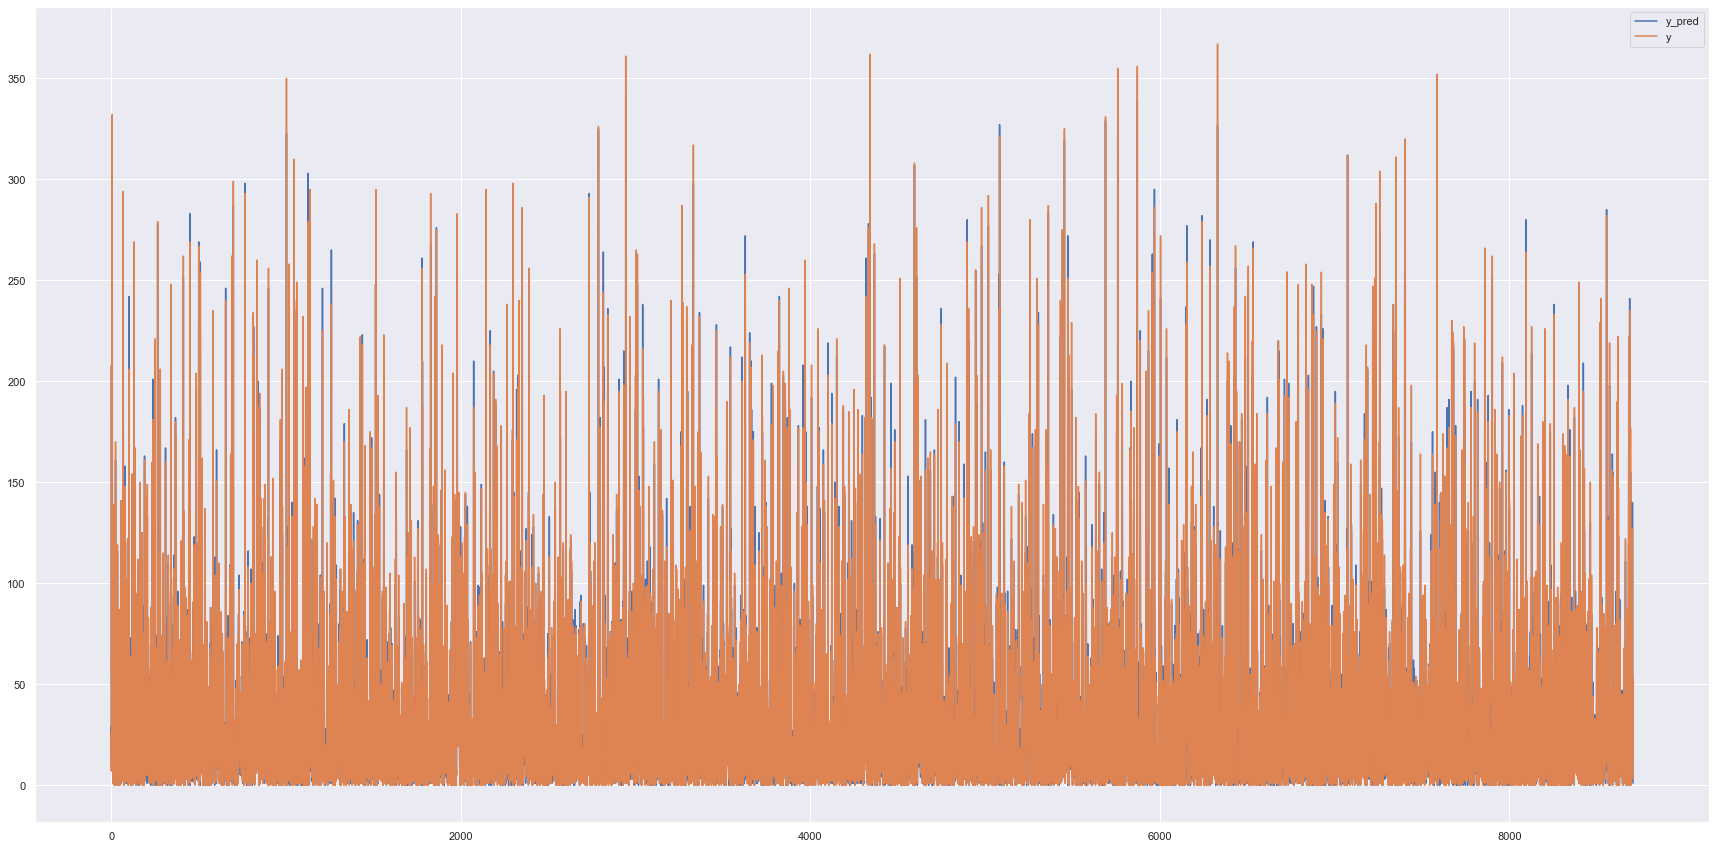

In [27]:
plt.rcParams["figure.figsize"] = (30,15)
visu_df.plot()
plt.show()

In [28]:
visu_df = pd.DataFrame([y_pred_test,y_test], index = ['y_pred','y'])
visu_df = visu_df.T
visu_df.head(5)

,y_pred,y
0,2,5
1,20,17
2,3,2
3,1,3
4,15,18


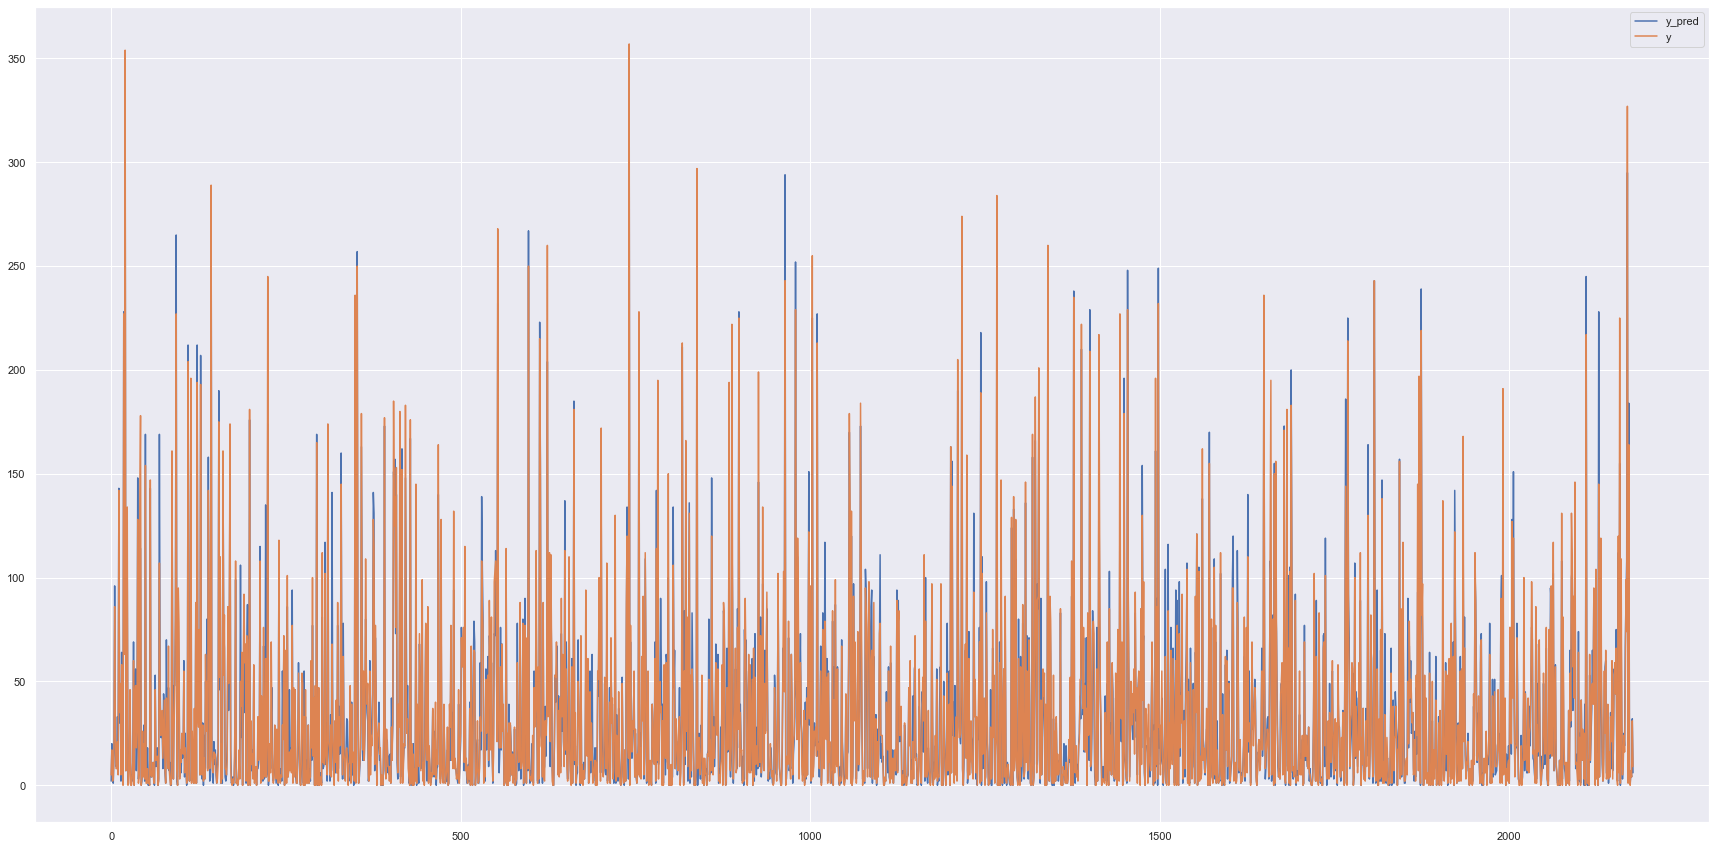

In [29]:
plt.rcParams["figure.figsize"] = (30,15)
visu_df.plot()
plt.show()

In [30]:
dif = y_pred_test-y_test
print(dif.sum())
print(f'y > y_pred の個数:  {len(dif[dif <0])}')
print(f'y = y_pred の個数:  {len(dif[dif ==0])}')
print(f'y < y_pred の個数:  {len(dif[dif >0])}')


-1435
y > y_pred の個数:  975
y = y_pred の個数:  253
y < y_pred の個数:  950


In [39]:
test_df = test_df.drop(['datetime','datetime_original'],axis=1)
test_df = test_df.astype(int)

In [40]:
#実際のtestデータの予測を作成
pred_test = opt_model.predict(test_df)

In [41]:
pred_test[pred_test<0]=0
pred_test = pred_test.astype(int)

In [42]:
pred_test

array([0, 0, 0, ..., 5, 4, 3])

In [ ]:
sub = pd.read_csv('./input/sampleSubmission.csv')
sub['count']=pred_test
sub.head(125)

,datetime,count
0,2011-01-20 00:00:00,11
1,2011-01-20 01:00:00,5
2,2011-01-20 02:00:00,5
3,2011-01-20 03:00:00,3
4,2011-01-20 04:00:00,3
...,...,...
120,2011-01-25 04:00:00,2
121,2011-01-25 05:00:00,4
122,2011-01-25 06:00:00,35
123,2011-01-25 07:00:00,81


In [48]:
%%time
#学習データの整形
df_y = train_df['casual']
#訓練・テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, shuffle=True)

#合計45万通りの組み合せすべて検証は多すぎる
cv_params ={'max_depth':[10,11,12],
            'min_child_weight':[3,4,5],
            'gamma':[0.4,0.5,0.6],
            'subsample':[0.7,0.8,0.9],
            'colsample_bytree':[ 0.9,1.0,1.1],
            'reg_alpha':[100, 150,200],
            'n_estimators':[1000],
            'reg_lambda':[0.1,1,10],
            'learning_rate':[0.1]
            }

model = xgb.XGBRegressor(silent=False,n_jobs=-1)
model_grid = GridSearchCV(model, cv_params, cv=5, n_jobs=-1)
model_grid.fit(X_train,
                y_train,
                early_stopping_rounds=50,
                eval_set=[(X_test, y_test)],
                eval_metric='rmsle',
                verbose=0)
print('optimal_parameters\n', model_grid.best_params_)

In [ ]:
#パラメータが最適化されたモデルを作成
opt_model = model_grid.best_estimator_
#予測
y_pred_train = opt_model.predict(X_train)
y_pred_test = opt_model.predict(X_test)

In [44]:
y_pred_train = y_pred_train.astype(int)
y_pred_train[y_pred_train<0] = 0
y_pred_test = y_pred_test.astype(int)
y_pred_test[y_pred_test<0] = 0

In [45]:
# 学習モデルの評価（RMSEを計算）
from sklearn.metrics import mean_squared_log_error
print('RMSE(train data):',round(np.sqrt(mean_squared_error(y_train, y_pred_train)),3))
print('RMSLE(train data):',round(np.sqrt(mean_squared_log_error(y_train, y_pred_train)),3))
print('RMSE(test data):',round(np.sqrt(mean_squared_error(y_test, y_pred_test)),3))
print('RMSLE(test data):',round(np.sqrt(mean_squared_log_error(y_test, y_pred_test)),3))

RMSE(train data): 6.81
RMSLE(train data): 0.386
RMSE(test data): 12.895
RMSLE(test data): 0.481


In [46]:
visu_df = pd.DataFrame([y_pred_train,y_train], index = ['y_pred','y'])
visu_df = visu_df.T
visu_df.head(5)

,y_pred,y
0,29,26
1,13,7
2,208,208
3,50,56
4,106,89


In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
visu_df.plot()
plt.show()

In [ ]:
visu_df = pd.DataFrame([y_pred_test,y_test], index = ['y_pred','y'])
visu_df = visu_df.T
visu_df.head(5)

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
visu_df.plot()
plt.show()

In [ ]:
dif = y_pred_test-y_test
print(dif.sum())
print(f'y > y_pred の個数:  {len(dif[dif <0])}')
print(f'y = y_pred の個数:  {len(dif[dif ==0])}')
print(f'y < y_pred の個数:  {len(dif[dif >0])}')


In [ ]:
#実際のtestデータの予測を作成
pred_test = opt_model.predict(test_df)

In [ ]:
pred_test[pred_test<0]=0
pred_test = pred_test.astype(int)
sub['count']+=pred_test

In [ ]:
sub.to_csv('Subm_1.csv', index=False)
"""
from google.colab import files
files.download('Subm_1.csv') 
"""
"""1回目　Score 0.53463
   2回目  Score 0.52750
   3回目  Score 0.60054
   4回目  Score 0.64267
   5回目  Score 0.67732
   """

'1回目\u3000Score 0.53463\n   2回目  Score 0.52750\n   3回目  Score 0.60054\n   4回目  Score 0.64267\n   5回目  Score 0.67732\n   '